### Data Understanding & Prepare Data

Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale
from scipy import stats

In [2]:
listing = pd.read_csv('listing.csv',low_memory=False)

In [3]:
listing.shape

(37048, 106)

Clean the data - only look at the LA market listings that received at least one review since 2019, scraped from Airbnb website on May 9, 2020.

In [4]:
#drop by rows
df=listing.drop(set(listing.columns[listing.isnull().mean()>=0.7]),axis=1)
df=df.dropna(subset=['market'])
df=df[(df['last_review']>='2019-01-01') &(df['market'].str.contains('Los Angeles'))]
#drop by columns
df=df.drop([col for col in df.columns if ('url' in col) or ('scrape' in col)] ,axis=1)
df=df.drop(['host_total_listings_count','state','smart_location', 'country_code', 'country','calendar_updated',
            'jurisdiction_names','neighborhood_overview','has_availability','market','experiences_offered'],axis=1)

In [5]:
#Define labels - 1: high occupancy rate; 0:low occupancy rate.
df.loc[df['availability_30'] < 21, 'days'] = 1
df.loc[df['availability_30'] >= 21, 'days'] = 0

Descriptive Statistics

In [6]:
print(df[['availability_30','availability_60','availability_90','availability_365']].describe().astype(int))

       availability_30  availability_60  availability_90  availability_365
count            24283            24283            24283             24283
mean                16               35               54               181
std                 12               24               35               137
min                  0                0                0                 0
25%                  0                5               14                61
50%                 21               44               67               173
75%                 30               59               89               336
max                 30               60               90               365


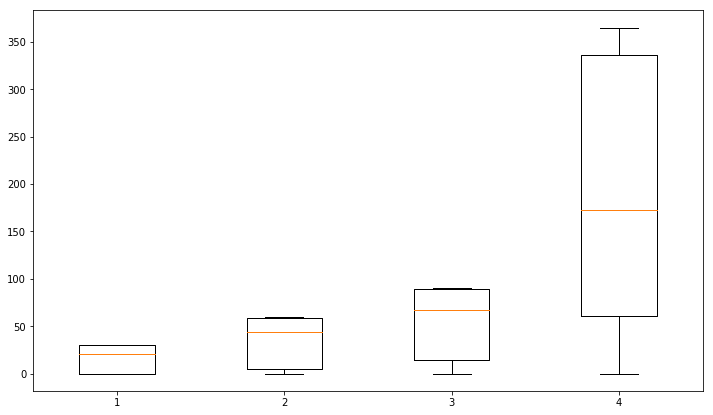

In [8]:
fig= plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.boxplot([df.availability_30,df.availability_60,df.availability_90,df.availability_365])
#ax.set_xlabel(['availability_30','availability_60','availability_90','availability_365'])
plt.show()

Convert price, percentages ro numeric type and impute missing values

In [9]:
df['first_review']=pd.to_datetime(df['first_review'])
df['last_review']=pd.to_datetime(df['last_review'])
fill_mean = lambda col: col.fillna("$0") 
df["security_deposit"] = df[["security_deposit"]].apply(fill_mean, axis=0)
df["cleaning_fee"] = df[["cleaning_fee"]].apply(fill_mean, axis=0)
df["extra_people"] = df[["extra_people"]].apply(fill_mean, axis=0)

In [10]:
df['host_response_rate']=df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
df['host_acceptance_rate']=df['host_acceptance_rate'].str.replace(r'%', r'.0').astype('float') / 100.0

In [11]:
locale.setlocale(locale.LC_ALL,'')
df.security_deposit=df.security_deposit.map(lambda x: locale.atof(x.strip('$'))).astype(int)
df.price=df.price.map(lambda x: locale.atof(x.strip('$'))).astype(int)
df.cleaning_fee=df.cleaning_fee.map(lambda x: locale.atof(x.strip('$'))).astype(int)
df.extra_people=df.extra_people.map(lambda x: locale.atof(x.strip('$'))).astype(int)

Remove Outliers

In [13]:
df=df[df.price<=1000]
df.shape

(24056, 81)

Two-sample comparisons

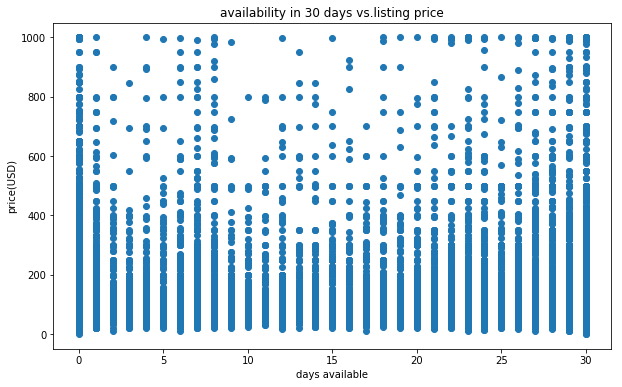

In [14]:
#plt.scatter(df['availability_30'],df['number_of_reviews_ltm'])
fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(df['availability_30'],df['price'])
ax.set_title("availability in 30 days vs.listing price")
ax.set_xlabel("days available")
ax.set_ylabel("price(USD)")

plt.show()

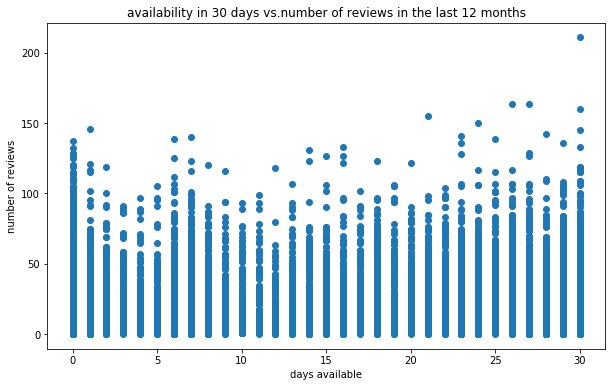

In [16]:
#plt.scatter(df['availability_30'],df['number_of_reviews_ltm'])
fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(df['availability_30'],df['number_of_reviews_ltm'])
ax.set_title("availability in 30 days vs.number of reviews in the last 12 months")
ax.set_xlabel("days available")
ax.set_ylabel("number of reviews")

plt.show()

days
0.0    17.155653
1.0    17.698454
Name: number_of_reviews_ltm, dtype: float64


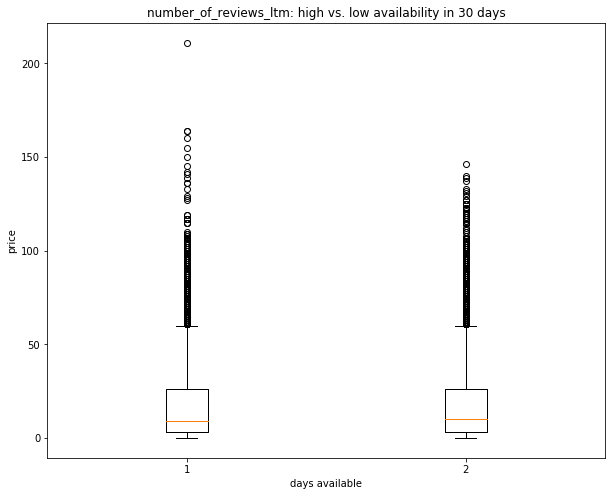

In [129]:
print(df.groupby(['days']).mean()['number_of_reviews_ltm'].dropna())

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.boxplot([df[df.days==0]['number_of_reviews_ltm'].dropna(),df[df.days==1]['number_of_reviews_ltm'].dropna()])
ax.set_title("number_of_reviews_ltm: high vs. low availability in 30 days")
ax.set_xlabel("days available")
ax.set_ylabel("price")

plt.show()

days
0.0    0.893996
1.0    0.908460
Name: host_acceptance_rate, dtype: float64


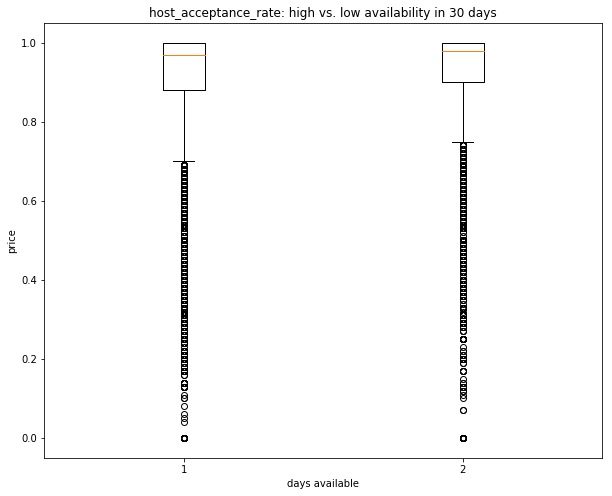

In [130]:
print(df.groupby(['days']).mean()['host_acceptance_rate'].dropna())

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.boxplot([df[df.days==0]['host_acceptance_rate'].dropna(),df[df.days==1]['host_acceptance_rate'].dropna()])
ax.set_title("host_acceptance_rate: high vs. low availability in 30 days")
ax.set_xlabel("days available")
ax.set_ylabel("price")

plt.show()

days
0.0    151.510049
1.0    143.425157
Name: price, dtype: float64


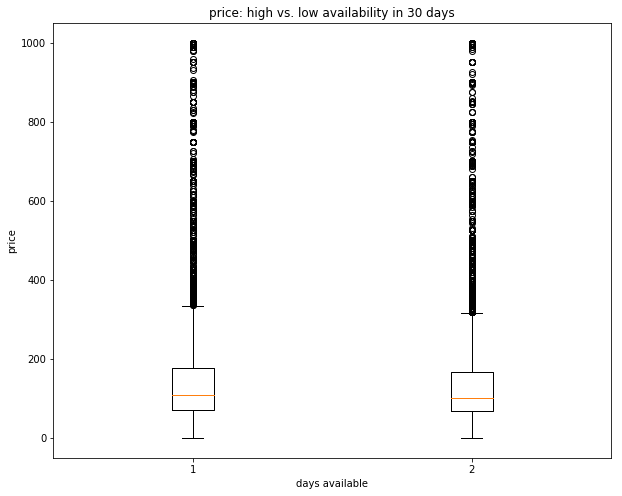

In [131]:
print(df.groupby(['days']).mean()['price'].dropna())

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.boxplot([df[df.days==0]['price'].dropna(),df[df.days==1]['price'].dropna()])
ax.set_title("price: high vs. low availability in 30 days")
ax.set_xlabel("days available")
ax.set_ylabel("price")

plt.show()

In [35]:
df.groupby(['days']).mean()['host_response_rate'].sort_values(ascending=False).dropna()

days
1.0    0.960476
0.0    0.945897
Name: host_response_rate, dtype: float64

In [36]:
df.groupby(['days']).mean()['review_scores_rating'].sort_values(ascending=False).dropna()

days
1.0    94.914730
0.0    93.647073
Name: review_scores_rating, dtype: float64

In [48]:
df.groupby(['host_is_superhost']).mean()['days'].sort_values(ascending=False).dropna()

host_is_superhost
t    0.531668
f    0.470656
Name: days, dtype: float64

In [52]:
df.groupby(['room_type']).mean()['days'].sort_values(ascending=False).dropna()

room_type
Entire home/apt    0.516742
Private room       0.479786
Hotel room         0.352941
Shared room        0.230061
Name: days, dtype: float64

In [17]:
print(stats.ttest_ind(df[df.room_type=='Entire home/apt']['days'].dropna(),df[df.room_type=='Private room']['days'].dropna()))
print(stats.ttest_ind(df[df.days==1]['accommodates'].dropna(),df[df.days==0]['accommodates'].dropna()))
print(stats.ttest_ind(df[df.days==1]['price'],df[df.days==0]['price']))

print(stats.ttest_ind(df[df.days==1]['host_acceptance_rate'].dropna(),df[df.days==0]['host_acceptance_rate'].dropna()))
print(stats.ttest_ind(df[df.days==1]['host_response_rate'].dropna(),df[df.days==0]['host_response_rate'].dropna()))
print(stats.ttest_ind(df[df.host_is_superhost=='t']['days'].dropna(),df[df.host_is_superhost=='f']['days'].dropna()))

print(stats.ttest_ind(df[df.days==1]['number_of_reviews_ltm'].dropna(),df[df.days==0]['number_of_reviews_ltm'].dropna()))
print(stats.ttest_ind(df[df.days==1]['reviews_per_month'].dropna(),df[df.days==0]['reviews_per_month'].dropna()))

Ttest_indResult(statistic=5.378750371906785, pvalue=7.572854990671971e-08)
Ttest_indResult(statistic=-2.8023140875979506, pvalue=0.005077801342555532)
Ttest_indResult(statistic=-4.139761010374314, pvalue=3.4885195610043844e-05)
Ttest_indResult(statistic=6.713759463012128, pvalue=1.9397157812946656e-11)
Ttest_indResult(statistic=7.330986705171544, pvalue=2.3667918610423353e-13)
Ttest_indResult(statistic=11.410647863277553, pvalue=4.421593025234187e-30)
Ttest_indResult(statistic=3.77250371369404, pvalue=0.00016200484800762434)
Ttest_indResult(statistic=4.231241553335714, pvalue=2.3326516129862234e-05)


### Model Data

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc

Select features to use

In [14]:
features = ['host_response_time', 
    #'host_response_rate', 
    'host_acceptance_rate',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
        'neighbourhood_cleansed','is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
         'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews_ltm', 
    #'review_scores_rating', 
    'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification','reviews_per_month','host_is_superhost',
          'price','days'
    #, 'availability_30'
            ]

df1=df.loc[:, features]

In [15]:
df1.shape

(24056, 37)

Impute Nan and encode categorical variables

In [16]:
#fill_mean = lambda col: col.fillna("f") 
for i in df1.select_dtypes(include=['object']).columns:
    if 'f' in set(df1[i]):
        df1[i] = df1[i].fillna("f")
    else:
        df1[i] = df1[i].fillna("other")
df1=df1.dropna()

In [17]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, 
                                                                 dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df
df1=create_dummy_df(df1, df1.select_dtypes(include=['object']), dummy_na=False)

In [18]:
X=df1.loc[:,df1.columns!='days'].values
y = np.ravel(df1.loc[:,['days']].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

K-nearest neighbors

In [105]:
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred1 = classifier.predict(X_test)
accuracy=accuracy_score(y_test,y_pred1)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 57.74 %.


In [105]:
classifier = KNeighborsClassifier(n_neighbors = 100, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 56.95 %.


In [106]:
classifier = KNeighborsClassifier(n_neighbors = 1000, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 56.8 %.


Support Vector Machine

In [106]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

y_pred2 = classifier.predict(X_test)

C:\Users\xyzou\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [110]:
accuracy=accuracy_score(y_test,y_pred2)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 60.99 %.


Decision Tree

In [107]:
dtree = tree.DecisionTreeClassifier(random_state=0)
    #rclass_weight="balanced",min_weight_fraction_leaf=0.01,)
dtree = dtree.fit(X_train,y_train)

y_pred3 =dtree.predict(X_test)

In [23]:
accuracy=accuracy_score(y_test,y_pred3)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 57.16 %.


Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [21]:
y_pred = rf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 64.27 %.


In [69]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(df1.loc[:,df1.columns!='days'].columns, 
                                                                                      importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[1:35]
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: number_of_reviews_ltm Importance: 0.06
Variable: price                Importance: 0.06
Variable: cleaning_fee         Importance: 0.05
Variable: host_acceptance_rate Importance: 0.04
Variable: host_listings_count  Importance: 0.04
Variable: security_deposit     Importance: 0.04
Variable: extra_people         Importance: 0.04
Variable: maximum_nights       Importance: 0.04
Variable: accommodates         Importance: 0.03
Variable: beds                 Importance: 0.03
Variable: minimum_nights       Importance: 0.03
Variable: bathrooms            Importance: 0.02
Variable: bedrooms             Importance: 0.02
Variable: guests_included      Importance: 0.02
Variable: review_scores_cleanliness Importance: 0.02
Variable: review_scores_value  Importance: 0.02
Variable: host_response_time_other Importance: 0.02
Variable: review_scores_accuracy Importance: 0.01
Variable: review_scores_checkin Importance: 0.01
Variable: review_scores_communication Importance: 0.01
Variable: review_sco

### Plot the result

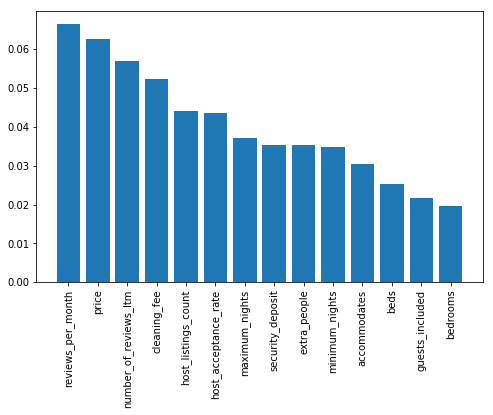

In [25]:
f=pd.DataFrame([df1.loc[:,df1.columns!='days'].columns,importances])
f=np.transpose(f)
f=f.sort_values(f.columns[1],ascending=False).iloc[0:14]

fig= plt.figure(figsize=(8,5))
plt.bar(f[0],f[1])
plt.xticks(rotation=90)
plt.show()

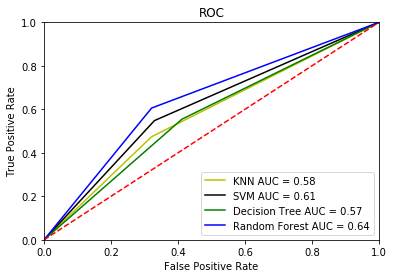

In [119]:
fpr, tpr, _ = roc_curve(y_test, y_pred)  
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)  
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)  
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)  

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.title('ROC')
plt.plot(fpr1, tpr1, 'y', label='KNN AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'black', label='SVM AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'g', label='Decision Tree AUC = %0.2f' % roc_auc3)
plt.plot(fpr, tpr, 'b', label='Random Forest AUC = %0.2f' % roc_auc)


plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Check the Splits

In [79]:
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print (node)

In [ ]:
get_lineage(rf.estimators_[0], X_test[:,12])

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'l', 0.9070011973381042, -0.7990575967724357)
(7, 'l', 1.2963390946388245, -0.8495272455238019)
(8, 'l', -1.2197427153587341, -0.7990575967724357)
(9, 'l', 0.021852299571037292, -0.29436110925877373)
(10, 'l', 0.12175637483596802, -0.899996894275168)
(11, 'l', 4.9965150356292725, 0.46268362201171914)
(12, 'l', 0.4340387284755707, 0.26080502700625435)
(13, 'l', 4.4446920827031136, -0.5971790017669709)
(14, 'l', 0.4070180058479309, 0.7655015145199163)
15
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.193421811756

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'l', 0.9070011973381042, -0.7990575967724357)
(7, 'l', 1.2963390946388245, -0.8495272455238019)
(8, 'r', -1.2197427153587341, -0.7990575967724357)
(22, 'r', -0.8056731522083282, -0.8495272455238019)
(66, 'l', 0.09758204221725464, -0.5467093530156047)
(67, 'r', -0.9784702360630035, -0.04201286550194279)
(75, 'l', 3.0193828716874123, -0.7485879480210695)
(76, 'l', 0.2294376790523529, -0.29436110925877373)
(77, 'l', -0.6488496661186218, -0.7990575967724357)
(78, 'r', -1.0370365679264069, -0.6981182992697033)
(92, 'r', -0.34135910868644714, 0.7150318657685502)
(106, 'r', -0.34591837227344513, -0.04201286550194279)
(108, 'l', 7.626431372016668, -0.04201286550194279)
(109, 'l', 0.057537391781806

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'l', 0.9070011973381042, -0.7990575967724357)
(7, 'l', 1.2963390946388245, -0.8495272455238019)
(8, 'r', -1.2197427153587341, -0.7990575967724357)
(22, 'r', -0.8056731522083282, -0.8495272455238019)
(66, 'r', 0.09758204221725464, -0.5467093530156047)
(196, 'l', 9.707226976752281, 0.5636229195144515)
(197, 'l', 3.475040890276432, -0.6476486505183371)
(198, 'l', 1.0348954796791077, -0.29436110925877373)
(199, 'l', 25.77027844171971, -0.44577005551287235)
(200, 'l', -0.27707062661647797, -0.29436110925877373)
(201, 'l', 0.05471460986882448, -0.04201286550194279)
(202, 'l', 0.12175637483596802, -0.899996894275168)
(203, 'r', -0.9121368825435638, -0.6476486505183371)
(207, 'l', 5.24006655067205

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'l', 0.9070011973381042, -0.7990575967724357)
(7, 'r', 1.2963390946388245, -0.8495272455238019)
(339, 'l', -0.12950243800878525, -0.8495272455238019)
(340, 'l', 1.933854416012764, -0.7990575967724357)
(341, 'l', -0.9121368825435638, -0.6476486505183371)
342
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'l', 0.9070011973381042, -0.7990575967724357)
(7, 'r', 1.2963390946388245, -0.8495272455238019)
(339, 'l', -0.12950243800878525, -0.849527

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'r', 0.9070011973381042, -0.7990575967724357)
(362, 'l', -1.0370365679264069, -0.6981182992697033)
(363, 'r', -1.0997458696365356, -0.04201286550194279)
(371, 'r', -1.0004634261131287, 0.5636229195144515)
(373, 'l', 5.144773405045271, 3.2385143033368595)
(374, 'r', 0.6042664498090744, -0.14295216300467517)
(458, 'r', -0.32699190080165863, 0.9169104607740148)
(464, 'r', 0.4299146607518196, -0.29436110925877373)
468
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'r', 0.9070011973381042, -0.7990575967724357)
(362, 'r', -1.0370365679264069, -0.6981182992697033)
(470, 'r', -0.9698710143566132, 0.5636229195144515)
(476, 'r', -1.385027825832367, -0.29436110925877373)
(478, 'l', 11.181873351335526, 0.7655015145199163)
(479, 'l', 20.550937389954925, -0.29436110925877373)
(480, 'l', -0.08774511516094208, -0.8495272455238019)
(481, 'l', 13.616546647623181, -0.8495272455238019)
(482, 'l', 24.10394393093884, -0.8495272455238019)
(483, 'l', 5.223829425871372, -0.7485879480210695)
(484, 'l', 0.32321909815073013, -0.6476486505183371)
(485, 'l', 6.732798121869564, 1.4216069482876768)
(486, 'l', 0.8716462850570679, -0.14295216300467517)
(487, 'l', 0.4070180058479

(481, 'l', 13.616546647623181, -0.8495272455238019)
(482, 'l', 24.10394393093884, -0.8495272455238019)
(483, 'l', 5.223829425871372, -0.7485879480210695)
(484, 'l', 0.32321909815073013, -0.6476486505183371)
(485, 'l', 6.732798121869564, 1.4216069482876768)
(486, 'l', 0.8716462850570679, -0.14295216300467517)
(487, 'r', 0.4070180058479309, 0.7655015145199163)
(579, 'l', 10.021203868091106, -0.7485879480210695)
(580, 'l', 3.739273279905319, -0.7485879480210695)
(581, 'l', 9.808617785573006, 0.26080502700625435)
(582, 'r', -0.7118327915668488, -0.7990575967724357)
(606, 'l', 12.02862948179245, 2.9356964108286623)
(607, 'l', 1.6425890922546387, -0.7990575967724357)
(608, 'r', 0.3064192831516266, -0.7990575967724357)
(632, 'l', 9.243155123665929, -0.5971790017669709)
(633, 'l', 0.07759812474250793, -0.6981182992697033)
(634, 'l', -0.29405681788921356, 0.5636229195144515)
(635, 'l', 5.144773405045271, 1.0178497582767472)
(636, 'l', -0.21616503596305847, -0.7990575967724357)
(637, 'l', 0.5151

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'r', 0.9070011973381042, -0.7990575967724357)
(362, 'r', -1.0370365679264069, -0.6981182992697033)
(470, 'r', -0.9698710143566132, 0.5636229195144515)
(476, 'r', -1.385027825832367, -0.29436110925877373)
(478, 'l', 11.181873351335526, 0.7655015145199163)
(479, 'l', 20.550937389954925, -0.29436110925877373)
(480, 'l', -0.08774511516094208, -0.8495272455238019)
(481, 'l', 13.616546647623181, -0.8495272455238019)
(482, 'l', 24.10394393093884, -0.8495272455238019)
(483, 'l', 5.223829425871372, -0.7485879480210695)
(484, 'r', 0.32321909815073013, -0.6476486505183371)
(698, 'r', -0.8109663724899292, -0.7990575967724357)
(700, 'l', 8.69171422533691, 0.9169104607740148)
(701, 'l', 0.77517050504684

(795, 'l', 3.72687054425478, -0.44577005551287235)
(796, 'r', 1.091228574514389, -0.6476486505183371)
(820, 'l', -0.2707682102918625, 0.6140925682658177)
(821, 'l', 1.933854416012764, -0.7990575967724357)
(822, 'l', 0.10016285628080368, -0.8495272455238019)
823
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'l', -0.14103375375270844, -0.8495272455238019)
(4, 'l', 4.538896888494492, -0.19342181175604137)
(5, 'l', 1.6452454179525375, -0.7990575967724357)
(6, 'r', 0.9070011973381042, -0.7990575967724357)
(362, 'r', -1.0370365679264069, -0.6981182992697033)
(470, 'r', -0.9698710143566132, 0.5636229195144515)
(476, 'r', -1.385027825832367, -0.29436110925877373)
(478, 'l', 11.181873351335526, 0.7655015145199163)
(479, 'l', 20.550937389954925, -0.29436110925877373)
(480, 'r', -0.08774511516094208, -0.8495272455238019)
(752, 'l', 7.626431372016668, -0.04201286550194279)
(753, 'l', 3.739273279

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'l', 0.07759812474250793, -0.6981182992697033)
(971, 'l', -0.37612611055374146, -0.14295216300467517)
(972, 'l', 1.3699718117713928, -0.7990575967724357)
(973, 'l', 68.21473434730433, 2.986166059580029)
(974, 'l', -0.4206894189119339, -0.14295216300467517)
(975, 'l', 0.07504650950431824, -0.7990575967724357)
(976, 'l', -0.1235371045768261, -0.8495272455238019)
(977, 'r', 0.4380622

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'l', 0.07759812474250793, -0.6981182992697033)
(971, 'l', -0.37612611055374146, -0.14295216300467517)
(972, 'r', 1.3699718117713928, -0.7990575967724357)
(1074, 'r', 0.045383989810943604, 1.9767730845527047)
(1088, 'l', -0.6032304167747498, -0.8495272455238019)
1089
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'l', -0.7912129461765289, -0.8495272455238019)
(1147, 'l', 2.668276220560074, 2.582408869569099)
(1148, 'l', 13.616546647623181, -0.8495272455238019)
(1149, 'l', 4.5281472615897655, 1.3206676507849444)
(1150, 'l', 2.848618268966675, 0.5636229195144515)
(1151, 'l', 1.6042204648256302, -0.09248251425330899)
(1152, 'r', -0.7680617

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'l', -0.7912129461765289, -0.8495272455238019)
(1147, 'l', 2.668276220560074, 2.582408869569099)
(1148, 'l', 13.616546647623181, -0.8495272455238019)
(1149, 'l', 4.5281472615897655, 1.3206676507849444)
(1150, 'l', 2.848618268966675, 0.5636229195144515)
(1151, 'l', 1.6042204648256302, -0.09248251425330899)
(1152, 'r', -0.7680617

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'l', -0.34135910868644714, 0.7150318657685502)
(1289, 'l', -0.28684820234775543, -0.8495272455238019)
(1290, 'r', -0.9956741780042648, -0.8495272455238019)
(1292, 'r', -0.8532108068466187, -0.6476486505183371)
(1304, 'l', 22.72358262166381, -0.6476486505183371)
(1305, 'l', 1

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'l', -0.34135910868644714, 0.7150318657685502)
(1289, 'r', -0.28684820234775543, -0.8495272455238019)
(1389, 'l', 7.179368864744902, -0.7990575967724357)
(1390, 'r', -1.2187864184379578, -0.7990575967724357)
(1392, 'r', 0.3064192831516266, -0.7990575967724357)
(1420, 'l', 6.

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'l', -0.08177978172898293, -0.8495272455238019)
(1468, 'l', 0.12175637483596802, -0.899996894275168)
(1469, 'r', -0.747832328081131, -0.8495272455238019)
(1501, 'l', 6

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'l', -0.08177978172898293, -0.8495272455238019)
(1468, 'r', 0.12175637483596802, -0.899996894275168)
(1592, 'r', -1.225480318069458, -0.7990575967724357)
(1594, 'l', 2

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'l', -0.08177978172898293, -0.8495272455238019)
(1468, 'r', 0.12175637483596802, -0.899996894275168)
(1592, 'r', -1.225480318069458, -0.7990575967724357)
(1594, 'l', 2

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'l', -0.08177978172898293, -0.8495272455238019)
(1468, 'r', 0.12175637483596802, -0.899996894275168)
(1592, 'r', -1.225480318069458, -0.7990575967724357)
(1594, 'l', 2

(1595, 'l', 15.229913778603077, -0.34483075801013996)
(1596, 'l', 2.662282705307007, 0.5636229195144515)
(1597, 'l', 24.10394393093884, -0.8495272455238019)
(1598, 'l', 2.410874128341675, -0.7990575967724357)
(1599, 'l', -0.10564111173152924, -0.8495272455238019)
(1600, 'l', 11.181873351335526, 0.26080502700625435)
(1601, 'l', 20.550937389954925, -0.899996894275168)
(1602, 'l', 5.502608325332403, 2.481469572066367)
(1603, 'l', -0.2938380683772266, -0.6476486505183371)
(1604, 'l', -0.31242523062974215, 4.853543063380577)
(1605, 'r', 0.31744980812072754, -0.04201286550194279)
(1651, 'r', 0.5586746037006378, -0.04201286550194279)
(1717, 'l', 39.377448903396726, -0.7990575967724357)
(1718, 'r', -1.2025298476219177, -0.7990575967724357)
(1726, 'l', 3.739273279905319, -0.7485879480210695)
(1727, 'l', 17.59309160336852, -0.8495272455238019)
(1728, 'r', 0.057537391781806946, -0.8495272455238019)
(1736, 'r', 1.933854416012764, -0.7990575967724357)
(1800, 'l', -2.1839367896318436, -0.24389146050

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'l', -0.08177978172898293, -0.8495272455238019)
(1468, 'r', 0.12175637483596802, -0.899996894275168)
(1592, 'r', -1.225480318069458, -0.7990575967724357)
(1594, 'l', 2

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'l', -0.08177978172898293, -0.8495272455238019)
(1468, 'r', 0.12175637483596802, -0.899996894275168)
(1592, 'r', -1.225480318069458, -0.7990575967724357)
(1594, 'l', 2

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'l', -0.4610675275325775, -0.6476486505183371)
(968, 'l', 5.144773405045271, 1.0178497582767472)
(969, 'l', 6.302469432353973, -0.6981182992697033)
(970, 'r', 0.07759812474250793, -0.6981182992697033)
(1146, 'r', -0.7912129461765289, -0.8495272455238019)
(1288, 'r', -0.34135910868644714, 0.7150318657685502)
(1466, 'l', 0.6924830377101898, -0.04201286550194279)
(1467, 'r', -0.08177978172898293, -0.8495272455238019)
(1993, 'l', 4.496329668909311, -0.44577005551287235)
(1994, 'r', 1.2077524662017822, 0.5636229195144515)
(2028, 'r', 0.

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'r', -0.4610675275325775, -0.6476486505183371)
(2075, 'l', -0.4277794659137726, -0.8495272455238019)
(2076, 'l', 5.6389174573123455, 0.0589264320007896)
(2077, 'l', 7.626431372016668, -0.04201286550194279)
(2078, 'l', 21.555745433084667, -0.6981182992697033)
(2079, 'r', 0.045383989810943604, 1.9767730845527047)
(2143, 'l', 1.9654988646507263, -0.8495272455238019)
(2144, 'l', -0.31242523062974215, 4.853543063380577)
(2145, 'l', -0.34135910868644714, 0.7150318657685502)
(2146, 'l', 1.6042204648256302, -0.09248251425330899)
(2147, 'r'

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'r', -0.4610675275325775, -0.6476486505183371)
(2075, 'r', -0.4277794659137726, -0.8495272455238019)
(2175, 'l', 1.2963390946388245, -0.8495272455238019)
(2176, 'r', -1.0825374126434326, -0.29436110925877373)
(2178, 'l', 0.4380622059106827, -0.04201286550194279)
(2179, 'l', 1.899129718542099, -0.8495272455238019)
(2180, 'l', 0.7153624296188354, -0.6476486505183371)
(2181, 'l', 8.352606747299433, 1.8758337870499724)
(2182, 'l', 5.502608325332403, 2.481469572066367)
(2183, 'r', 0.3064192831516266, -0.7990575967724357)
(2217, 'l', 8.2

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'l', -0.38632747530937195, -0.8495272455238019)
(895, 'l', 3.0022303983569145, 0.3112746757576206)
(896, 'r', -0.33360452950000763, 0.21033537825488818)
(966, 'l', 6.732798121869564, 1.4216069482876768)
(967, 'r', -0.4610675275325775, -0.6476486505183371)
(2075, 'r', -0.4277794659137726, -0.8495272455238019)
(2175, 'l', 1.2963390946388245, -0.8495272455238019)
(2176, 'r', -1.0825374126434326, -0.29436110925877373)
(2178, 'r', 0.4380622059106827, -0.04201286550194279)
(2264, 'r', 0.12175637483596802, -0.899996894275168)
(2296, 'l', 12.42512527294457, -0.7990575967724357)
(2297, 'l', 6.9087236151099205, -0.39530040676150613)
(2298, 'l', 11.032868694514036, -0.8495272455238019)
(2299, 'r', 0.057537391781806946, -0.8495272455238019)
(2305, 

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'l', -0.7118327915668488, -0.7990575967724357)
(2456, 'l', 3.8977351412177086, 0.008456783249423405)
(2457, 'l', 0.4125983268022537, -0.8495272455238019)
(2458, 'l', 3.475040890276432, -0.6476486505183371)
(2459, 'l', 5.223829425871372, -0.7485879480210695)
(2460, 'r', -0.8580408692359924, -0.6476486505183371)
(2484, 'l', -2.516941547393799, -0.04201286550194279)
(2485, 'r', -1.2044423818588257, -0.7990575967724357)
(2487, 'l', 5.829507417976856, -0.5467093530156047)
(2488, 'r', -4.08490264415741, -0.04201286550194279)
(2490, 'r', -0.4206894189119339, -0.14295216300467517)
(2496, 'l', 1.091228574514389, -0.6476486505183371)
(2497,

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'l', -0.7118327915668488, -0.7990575967724357)
(2456, 'l', 3.8977351412177086, 0.008456783249423405)
(2457, 'l', 0.4125983268022537, -0.8495272455238019)
(2458, 'l', 3.475040890276432, -0.6476486505183371)
(2459, 'l', 5.223829425871372, -0.7485879480210695)
(2460, 'r', -0.8580408692359924, -0.6476486505183371)
(2484, 'r', -2.516941547393799, -0.04201286550194279)
(2502, 'l', 5.797055244445801, -0.8495272455238019)
(2503, 'l', 4.9965150356292725, 0.46268362201171914)
(2504, 'l', 1.2963390946388245, -0.8495272455238019)
(2505, 'r', 0.13872459530830383, -0.39530040676150613)
(2585, 'r', -0.9809955358505249, 0.5636229195144515)
(2587,

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'r', -0.7118327915668488, -0.7990575967724357)
(2713, 'l', 9.707226976752281, 0.5636229195144515)
(2714, 'l', 16.056332858279347, -0.34483075801013996)
(2715, 'l', 7.020987764000893, -0.8495272455238019)
(2716, 'l', -1.1757543087005615, -0.7990575967724357)
(2717, 'l', -0.40808308124542236, 0.5636229195144515)
(2718, 'l', 0.1165938675403595, -0.6476486505183371)
(2719, 'r', -0.24172550439834595, -0.8495272455238019)
(2723, 'r', -0.4206894189119339, -0.14295216300467517)
(2725, 'l', -0.38964875787496567, -0.7990575967724357)
2726
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'r', -0.7118327915668488, -0.7990575967724357)
(2713, 'l', 9.707226976752281, 0.5636229195144515)
(2714, 'l', 16.056332858279347, -0.34483075801013996)
(2715, 'l', 7.020987764000893, -0.8495272455238019)
(2716, 'r', -1.1757543087005615, -0.7990575967724357)
(2804, 'l', 0.13872459530830383, -0.39530040676150613)
(2805, 'l', 0.006305046466877684, 0.5636229195144515)
(2806, 'l', 0.7881482839584351, -0.04201286550194279)
(2807, 'l', 1.6452454179525375, -0.7990575967724357)
(2808, 'l', 6.8015760481357574, -0.7485879480210695)
(2809, 'r', 0.41530171036720276, -0.7990575967724357)
(2827, 'l', 4.496329668909311, -0.44577005551287235)
(282

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'r', -0.7118327915668488, -0.7990575967724357)
(2713, 'l', 9.707226976752281, 0.5636229195144515)
(2714, 'l', 16.056332858279347, -0.34483075801013996)
(2715, 'l', 7.020987764000893, -0.8495272455238019)
(2716, 'r', -1.1757543087005615, -0.7990575967724357)
(2804, 'l', 0.13872459530830383, -0.39530040676150613)
(2805, 'r', 0.006305046466877684, 0.5636229195144515)
(2885, 'l', 0.17589061707258224, -0.04201286550194279)
(2886, 'l', 0.8716462850570679, -0.14295216300467517)
(2887, 'r', -0.28620436787605286, -0.29436110925877373)
(2931, 'r', 0.8907038867473602, 0.5636229195144515)
(2955, 'l', 2.668276220560074, 2.582408869569099)
(295

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'r', -0.7118327915668488, -0.7990575967724357)
(2713, 'l', 9.707226976752281, 0.5636229195144515)
(2714, 'l', 16.056332858279347, -0.34483075801013996)
(2715, 'l', 7.020987764000893, -0.8495272455238019)
(2716, 'r', -1.1757543087005615, -0.7990575967724357)
(2804, 'r', 0.13872459530830383, -0.39530040676150613)
(3030, 'l', -0.4206894189119339, -0.14295216300467517)
(3031, 'r', -2.1839367896318436, -0.24389146050740756)
(3043, 'l', 0.1165938675403595, -0.6476486505183371)
(3044, 'l', 3.739273279905319, -0.7485879480210695)
(3045, 'l', -0.00906223151832819, -0.04201286550194279)
(3046, 'r', -0.33360452950000763, 0.21033537825488818)

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'r', -0.7118327915668488, -0.7990575967724357)
(2713, 'l', 9.707226976752281, 0.5636229195144515)
(2714, 'l', 16.056332858279347, -0.34483075801013996)
(2715, 'l', 7.020987764000893, -0.8495272455238019)
(2716, 'r', -1.1757543087005615, -0.7990575967724357)
(2804, 'r', 0.13872459530830383, -0.39530040676150613)
(3030, 'r', -0.4206894189119339, -0.14295216300467517)
(3124, 'l', 10.75176909007132, -0.7485879480210695)
(3125, 'l', 0.25674381107091904, -0.8495272455238019)
(3126, 'l', 4.496329668909311, -0.44577005551287235)
(3127, 'r', -0.6474493592977524, -0.04201286550194279)
(3133, 'l', 5.144773405045271, 1.0178497582767472)
(3134

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'l', 0.3064192831516266, -0.7990575967724357)
(2455, 'r', -0.7118327915668488, -0.7990575967724357)
(2713, 'l', 9.707226976752281, 0.5636229195144515)
(2714, 'l', 16.056332858279347, -0.34483075801013996)
(2715, 'l', 7.020987764000893, -0.8495272455238019)
(2716, 'r', -1.1757543087005615, -0.7990575967724357)
(2804, 'r', 0.13872459530830383, -0.39530040676150613)
(3030, 'r', -0.4206894189119339, -0.14295216300467517)
(3124, 'l', 10.75176909007132, -0.7485879480210695)
(3125, 'l', 0.25674381107091904, -0.8495272455238019)
(3126, 'l', 4.496329668909311, -0.44577005551287235)
(3127, 'r', -0.6474493592977524, -0.04201286550194279)
(3133, 'l', 5.144773405045271, 1.0178497582767472)
(3134

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'r', 0.3064192831516266, -0.7990575967724357)
(3308, 'l', 0.4299146607518196, -0.29436110925877373)
(3309, 'l', -1.1738417744636536, -0.7990575967724357)
(3310, 'l', 3.475040890276432, -0.6476486505183371)
(3311, 'r', 0.057537391781806946, -0.8495272455238019)
(3321, 'r', 0.045383989810943604, 1.9767730845527047)
(3363, 'r', 0.2709547430276871, -0.29436110925877373)
3371
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'r', 0.3

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'r', 0.3064192831516266, -0.7990575967724357)
(3308, 'l', 0.4299146607518196, -0.29436110925877373)
(3309, 'r', -1.1738417744636536, -0.7990575967724357)
(3373, 'l', 10.889621457085013, -0.899996894275168)
(3374, 'r', -0.04732833616435528, -0.04201286550194279)
(3468, 'r', -1.1298989653587341, -0.04201286550194279)
(3478, 'l', 0.8455474674701691, -0.04201286550194279)
(3479, 'r', 0.20777903497219086, -0.04201286550194279)
(3503, 'r', -0.0754332672804594, -0.8495272455238019)
(3505, 'l', -0.3315628170967102, -0.14295216300467517)
(3506, 'l', 0.12175637483596802, -0.899996894275168)
(3507, 'l', 0.057537391781806946, -0.8495272455238019)
3508
(0, 'l', -0.2917589843273163, 1.47207659703

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'l', 2.577422618865967, 4.853543063380577)
(3, 'r', -0.14103375375270844, -0.8495272455238019)
(893, 'l', 5.240066550672054, -0.899996894275168)
(894, 'r', -0.38632747530937195, -0.8495272455238019)
(2454, 'r', 0.3064192831516266, -0.7990575967724357)
(3308, 'r', 0.4299146607518196, -0.29436110925877373)
(3564, 'l', 7.726098299026489, -0.39530040676150613)
(3565, 'l', 6.939036846160889, -0.6476486505183371)
(3566, 'l', 2.2839356660842896, -0.6476486505183371)
(3567, 'l', 1.2963390946388245, -0.8495272455238019)
(3568, 'l', 7.675787575542927, 0.21033537825488818)
(3569, 'r', -0.24121537804603577, 0.5636229195144515)
(3615, 'r', -0.2707682102918625, 0.6140925682658177)
(3617, 'r', 0.7153624296188354, -0.6476486505183371)
(3619, 'l', 1.1075057685375214, -0.6476486505183371)
(3620, 'r', -0.33360452950000763, 0.21033537825488818)
(3622, 'r', -0.6172962784767151, -0.04201286550194279)
(3624

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'r', 2.577422618865967, 4.853543063380577)
(3770, 'l', 17.59309160336852, -0.8495272455238019)
(3771, 'l', 4.034253478050232, -0.6476486505183371)
(3772, 'l', 10.021203868091106, -0.7485879480210695)
(3773, 'l', 0.9518887102603912, 0.5636229195144515)
(3774, 'r', -0.9956741780042648, -0.8495272455238019)
(3778, 'r', -0.044387382455170155, -0.04201286550194279)
(3780, 'l', -0.08476245030760765, -0.8495272455238019)
(3781, 'l', 4.9965150356292725, 0.46268362201171914)
(3782, 'l', 3.8977351412177086, 0.008456783249423405)
(3783, 'l', 5.502608325332403, 2.481469572066367)
(3784, 'r', 0.6861254870891571, -0.29436110925877373)
(3796, 'l', 0.19208033801987767, -0.8495272455238019)
3797
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'l', 0.3976750820875168, -0.8495272455238019)
(2, 'r', 2.577422618865967, 4.853543063380577)
(3770, 'l', 17.59309160336852, -0.8495272455238019)
(3771, 'l',

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'l', 0.6264701783657074, -0.7990575967724357)
(3830, 'l', 4.496329668909311, -0.44577005551287235)
(3831, 'l', 8.352606747299433, -0.8495272455238019)
(3832, 'l', -0.046536391600966454, 0.5636229195144515)
(3833, 'l', 4.166827246546745, -0.4962397042642385)
(3834, 'l', 4.4446920827031136, -0.5971790017669709)
(3835, 'l', 4.048580646514893, -0.6476486505183371)
(3836, 'r', -0.8562838137149811, -0.8495272455238019)
(3842, 'l', 39.377448903396726, -0.899996894275168)
(3843, 'l', 9.608884863555431, -0.04201286550194279)
(3844, 'l', 0.0047175344079732895, -0.8495272455238019)
(3845, 'l', 11.181873351335526, 0.26080502700625435)
(3846, 'l', 0.4340387284755707, 0.26080502700625435)
(3847, 'l', -0.34135910868644714, 0.7150318657685502)
(3848, 'l', 3.0193828716874123, -0.7485879480210695)
(3849, 'l', 5.829507417976856, -0.5467093530156047)
(3850, 'r', -0.8309784531593323, -0.849527245523801

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'l', 0.6264701783657074, -0.7990575967724357)
(3830, 'l', 4.496329668909311, -0.44577005551287235)
(3831, 'l', 8.352606747299433, -0.8495272455238019)
(3832, 'l', -0.046536391600966454, 0.5636229195144515)
(3833, 'l', 4.166827246546745, -0.4962397042642385)
(3834, 'l', 4.4446920827031136, -0.5971790017669709)
(3835, 'l', 4.048580646514893, -0.6476486505183371)
(3836, 'r', -0.8562838137149811, -0.8495272455238019)
(3842, 'l', 39.377448903396726, -0.899996894275168)
(3843, 'l', 9.608884863555431, -0.04201286550194279)
(3844, 'l', 0.0047175344079732895, -0.8495272455238019)
(3845, 'l', 11.181873351335526, 0.26080502700625435)
(3846, 'l', 0.4340387284755707, 0.26080502700625435)
(3847, 'r', -0.34135910868644714, 0.7150318657685502)
(3959, 'l', 15.229913778603077, -0.34483075801013996)
(3960, 'r', -0.6776024699211121, -0.04201286550194279)
(3976, 'r', -0.9956741780042648, -0.84952724552

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'l', 0.6264701783657074, -0.7990575967724357)
(3830, 'l', 4.496329668909311, -0.44577005551287235)
(3831, 'l', 8.352606747299433, -0.8495272455238019)
(3832, 'l', -0.046536391600966454, 0.5636229195144515)
(3833, 'l', 4.166827246546745, -0.4962397042642385)
(3834, 'l', 4.4446920827031136, -0.5971790017669709)
(3835, 'l', 4.048580646514893, -0.6476486505183371)
(3836, 'r', -0.8562838137149811, -0.8495272455238019)
(3842, 'l', 39.377448903396726, -0.899996894275168)
(3843, 'l', 9.608884863555431, -0.04201286550194279)
(3844, 'l', 0.0047175344079732895, -0.8495272455238019)
(3845, 'l', 11.181873351335526, 0.26080502700625435)
(3846, 'r', 0.4340387284755707, 0.26080502700625435)
(4082, 'r', -0.14103375375270844, -0.8495272455238019)
(4104, 'l', 10.021203868091106, -0.7485879480210695)
(4105, 'l', 6.064975965768099, -0.4962397042642385)
(4106, 'l', -0.17506616562604904, -0.2943611092587

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'l', 0.6264701783657074, -0.7990575967724357)
(3830, 'l', 4.496329668909311, -0.44577005551287235)
(3831, 'l', 8.352606747299433, -0.8495272455238019)
(3832, 'l', -0.046536391600966454, 0.5636229195144515)
(3833, 'l', 4.166827246546745, -0.4962397042642385)
(3834, 'l', 4.4446920827031136, -0.5971790017669709)
(3835, 'l', 4.048580646514893, -0.6476486505183371)
(3836, 'r', -0.8562838137149811, -0.8495272455238019)
(3842, 'r', 39.377448903396726, -0.899996894275168)
4214
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'l', 0.6264701783657074, -0.7990575967724357)
(3830, 'l', 4.496329668909311, -0.44577005551287235)
(3831, 'l', 8.352606747299433, -0.8495272455238019)
(3832, 'l', -0.046536391600966454, 0.5636229195144515)
(3833, 'l', 4.166827246546745, -0.4962397042642385)
(3834, 'l', 4.4446920827031136, -0.5971790017669709)
(38

(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'r', 0.6264701783657074, -0.7990575967724357)
(4373, 'l', -0.00906223151832819, -0.04201286550194279)
(4374, 'l', 5.502608325332403, 2.481469572066367)
(4375, 'r', -0.8317835032939911, -0.04201286550194279)
(4383, 'l', -0.11160644516348839, -0.8495272455238019)
(4384, 'l', 3.739273279905319, -0.7485879480210695)
(4385, 'r', -0.9956741780042648, -0.8495272455238019)
(4389, 'l', 1.5526124238967896, 0.5636229195144515)
(4390, 'r', 1.6042204648256302, -0.09248251425330899)
(4392, 'l', 0.5545291556045413, 4.853543063380577)
4393
(0, 'l', -0.2917589843273163, 1.472076597039043)
(1, 'r', 0.3976750820875168, -0.8495272455238019)
(3829, 'r', 0.6264701783657074, -0.7990575967724357)
(4373, 'l', -0.00906223151832819, -0.04201286550194279)
(4374, 'l', 5.502608325332403, 2.481469572066367)
(4375, 'r', -0.8317835032939911, -0.04201286550194279)
(4383, 'l', -0.11160644516348839, -0.84952724552380

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'l', -0.34135910868644714, 0.7150318657685502)
(4485, 'l', 7.348747439682484, 1.522546245790409)
(4486, 'l', 14.518806347623467, 0.21033537825488818)
(4487, 'r', -4.155308961868286, -0.8495272455238019)
(4493, 'r', -3.257796883583069, 0.9169104607740148)
(4505, 'l', 0.9997721314430237, -0.34483075801013996)
(4506, 'r', -0.7116818726062775, -0.8495272455238019)
(4526, 'l', 0.13080240413546562, -0.7990575967724357)
(4527, 'l', 8.994436632841825, -0.7990575967724357)
(4528, 'l', 5.700416706502438, -0.7990575967724357)
(4529, 'r', -6.220311265438795, -0.4962397042642385)
(4531, 'l', 0.3064192831516266, -0.79905759677243

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'l', -0.34135910868644714, 0.7150318657685502)
(4485, 'l', 7.348747439682484, 1.522546245790409)
(4486, 'l', 14.518806347623467, 0.21033537825488818)
(4487, 'r', -4.155308961868286, -0.8495272455238019)
(4493, 'r', -3.257796883583069, 0.9169104607740148)
(4505, 'l', 0.9997721314430237, -0.34483075801013996)
(4506, 'r', -0.7116818726062775, -0.8495272455238019)
(4526, 'r', 0.13080240413546562, -0.7990575967724357)
(4646, 'r', -0.06892421096563339, -0.6476486505183371)
(4658, 'l', 0.057537391781806946, -0.8495272455238019)
(4659, 'r', 0.24826322495937347, 0.5636229195144515)
4663
(0, 'r', -0.2917589843273163, 1.472076

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'l', -0.34135910868644714, 0.7150318657685502)
(4485, 'l', 7.348747439682484, 1.522546245790409)
(4486, 'l', 14.518806347623467, 0.21033537825488818)
(4487, 'r', -4.155308961868286, -0.8495272455238019)
(4493, 'r', -3.257796883583069, 0.9169104607740148)
(4505, 'r', 0.9997721314430237, -0.34483075801013996)
(4665, 'l', 1.091228574514389, -0.6476486505183371)
(4666, 'l', 2.665793463587761, -0.899996894275168)
(4667, 'l', 0.265544350259006, 4.853543063380577)
(4668, 'l', 4.538896888494492, -0.19342181175604137)
(4669, 'l', -0.06686645373702049, -0.8495272455238019)
(4670, 'l', 3.8428412675857544, -0.6981182992697033)


(4868, 'r', 0.13872459530830383, -0.39530040676150613)
(4882, 'r', -0.7622925341129303, -0.8495272455238019)
(4884, 'l', -0.14103375375270844, -0.8495272455238019)
(4885, 'l', -1.3053283989429474, -0.8495272455238019)
4886
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'l', -1.1757543087005615, -0.7990575967724357)
(4817, 'r', -0.9402041435241699, -0.04201286550194279)
(4833, 'r', -0.2657318189740181, -0.7990575967724357)
(4857, 'l', 3.4548187255859375, -0.29436110925877373)
(4858, 'l', 5.807400312274694, -0.5467093530156047)
(4859, 'l', -0.37612611055374146, -0.14295216300467517)
(4860, 'l', -0.2063160464167

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'l', -0.4556831866502762, -0.7990575967724357)
(4910, 'r', -3.257796883583069, 0.9169104607740148)
(4912, 'l', 7.179368864744902, -0.7990575967724357)
(4913, 'l', 7.883076373487711, -0.7485879480210695)
(4914, 'l', 0.3244607304222882, -0.6476486505183371)
(4915, 'l', 3.8096168488264084, 0.3112746757576206)
(4916, 'l', 6.666022676974535, -0.7485879480210695

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'l', -0.4556831866502762, -0.7990575967724357)
(4910, 'r', -3.257796883583069, 0.9169104607740148)
(4912, 'l', 7.179368864744902, -0.7990575967724357)
(4913, 'l', 7.883076373487711, -0.7485879480210695)
(4914, 'l', 0.3244607304222882, -0.6476486505183371)
(4915, 'l', 3.8096168488264084, 0.3112746757576206)
(4916, 'l', 6.666022676974535, -0.7485879480210695

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'r', -0.4556831866502762, -0.7990575967724357)
(5103, 'l', 2.121084213256836, -0.04201286550194279)
(5104, 'l', 0.3244607304222882, -0.6476486505183371)
(5105, 'l', 0.31744980812072754, -0.04201286550194279)
(5106, 'l', 3.8096168488264084, 0.3112746757576206)
(5107, 'l', 0.3064192831516266, -0.7990575967724357)
(5108, 'r', -0.8532108068466187, -0.647648650

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'r', -0.4556831866502762, -0.7990575967724357)
(5103, 'l', 2.121084213256836, -0.04201286550194279)
(5104, 'l', 0.3244607304222882, -0.6476486505183371)
(5105, 'r', 0.31744980812072754, -0.04201286550194279)
(5211, 'l', 0.3728327751159668, -0.8495272455238019)
(5212, 'l', 11.498777762055397, -0.7990575967724357)
(5213, 'l', -0.3321017324924469, -0.84952724

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'r', -0.4556831866502762, -0.7990575967724357)
(5103, 'l', 2.121084213256836, -0.04201286550194279)
(5104, 'l', 0.3244607304222882, -0.6476486505183371)
(5105, 'r', 0.31744980812072754, -0.04201286550194279)
(5211, 'l', 0.3728327751159668, -0.8495272455238019)
(5212, 'l', 11.498777762055397, -0.7990575967724357)
(5213, 'l', -0.3321017324924469, -0.84952724

(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'r', -0.4556831866502762, -0.7990575967724357)
(5103, 'l', 2.121084213256836, -0.04201286550194279)
(5104, 'l', 0.3244607304222882, -0.6476486505183371)
(5105, 'r', 0.31744980812072754, -0.04201286550194279)
(5211, 'l', 0.3728327751159668, -0.8495272455238019)
(5212, 'l', 11.498777762055397, -0.7990575967724357)
(5213, 'r', -0.3321017324924469, -0.8495272455238019)
(5377, 'l', 0.32321909815073013, -0.6476486505183371)
(5378, 'l', 1.9195682778954506, -0.4962397042642385)
(5379, 'r', -0.2489556148648262, -0.8495272455238019)
(5381, 'r', -2.1839367896318436, -0.24389146050740756)
(5389, 'l', 4.465142995119095, -0.19342181175604137)
(5390, 'l', 0.1812351942062378, -0.8495272455238019)
(5391, 'l', 4.175305396318436, -0.4962397042642385)
(5392, 'l', 4.116964686661959, -0.849527

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'l', 1.3597411513328552, -0.8495272455238019)
(4482, 'l', 3.8161970674991608, -0.5971790017669709)
(4483, 'l', 6.064975965768099, -0.7485879480210695)
(4484, 'r', -0.34135910868644714, 0.7150318657685502)
(4816, 'r', -1.1757543087005615, -0.7990575967724357)
(4906, 'l', 12.42512527294457, -0.5971790017669709)
(4907, 'l', 4.538896888494492, -0.19342181175604137)
(4908, 'l', 7.0596175491809845, 0.9169104607740148)
(4909, 'r', -0.4556831866502762, -0.7990575967724357)
(5103, 'l', 2.121084213256836, -0.04201286550194279)
(5104, 'r', 0.3244607304222882, -0.6476486505183371)
(5492, 'l', 8.994436632841825, -0.19342181175604137)
(5493, 'l', 0.01742956042289734, 0.5636229195144515)
(5494, 'l', -0.33360452950000763, 0.21033537825488818)
(5495, 'r', -0.2707682102918625, 0.614092568

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992697033)
(4481, 'r', 1.3597411513328552, -0.8495272455238019)
(5607, 'l', 2.065863311290741, -0.6476486505183371)
(5608, 'r', 0.045383989810943604, 1.9767730845527047)
(5618, 'r', -2.46962308883667, -0.8495272455238019)
(5620, 'r', 0.3244607304222882, -0.6476486505183371)
(5632, 'l', 8.994436632841825, 0.6140925682658177)
(5633, 'l', 0.5545291304588318, 4.853543063380577)
(5634, 'l', 2.617380790412426, -0.8495272455238019)
(5635, 'r', 1.4996490478515625, -0.6476486505183371)
(5647, 'r', 0.09758204221725464, -0.5467093530156047)
(5649, 'l', 0.5285215228796005, -0.04201286550194279)
5650
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'l', 0.07759812474250793, -0.6981182992

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'l', -0.6850967705249786, -0.04201286550194279)
(5662, 'r', -0.8201332986354828, -0.8495272455238019)
(5696, 'l', 1.2963390946388245, -0.8495272455238019)
(5697, 'r', 0.057537391781806946, -0.8495272455238019)
(5793, 'l', 0.9997721314430237, -0.34483075801013996)
(5794, 'l', 2.2896114587783813, 0.5636229195144515)
(5795, 'l', 4.8863998129963875, 0.0589264320007896)
(5796, 'l', 1.9336270093917847, 0.5636229195144515)
(5797, 'l', 0.4380622059106827, -0.04201286550194279)
(5798, 'r', -0.33360452950000763, 0.21033537825488818)
(5800, 'l', 0.2037651613354683, 0.5636229195144515)
(5801, 'l', -0.3747095465660095, 0.5636229195144515)
(5802, 'r', -0.76952263712883, -0.8495272455238019)
(5806, 'l', 10.132759811356664, 1.6234855

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'l', -0.6850967705249786, -0.04201286550194279)
(5662, 'r', -0.8201332986354828, -0.8495272455238019)
(5696, 'l', 1.2963390946388245, -0.8495272455238019)
(5697, 'r', 0.057537391781806946, -0.8495272455238019)
(5793, 'l', 0.9997721314430237, -0.34483075801013996)
(5794, 'l', 2.2896114587783813, 0.5636229195144515)
(5795, 'l', 4.8863998129963875, 0.0589264320007896)
(5796, 'l', 1.9336270093917847, 0.5636229195144515)
(5797, 'r', 0.4380622059106827, -0.04201286550194279)
(5905, 'l', -0.10565086081624031, -0.8495272455238019)
(5906, 'r', -0.2707682102918625, 0.6140925682658177)
(5916, 'l', -0.2063160464167595, -0.8495272455238019)
(5917, 'l', -0.22015457600355148, -0.14295216300467517)
(5918, 'l', 0.3042861223220825, -0.

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'l', -0.6850967705249786, -0.04201286550194279)
(5662, 'r', -0.8201332986354828, -0.8495272455238019)
(5696, 'l', 1.2963390946388245, -0.8495272455238019)
(5697, 'r', 0.057537391781806946, -0.8495272455238019)
(5793, 'l', 0.9997721314430237, -0.34483075801013996)
(5794, 'l', 2.2896114587783813, 0.5636229195144515)
(5795, 'l', 4.8863998129963875, 0.0589264320007896)
(5796, 'l', 1.9336270093917847, 0.5636229195144515)
(5797, 'r', 0.4380622059106827, -0.04201286550194279)
(5905, 'l', -0.10565086081624031, -0.8495272455238019)
(5906, 'r', -0.2707682102918625, 0.6140925682658177)
(5916, 'l', -0.2063160464167595, -0.8495272455238019)
(5917, 'r', -0.22015457600355148, -0.14295216300467517)
(5997, 'r', 0.4340387284755707, 0.2

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'l', -0.6850967705249786, -0.04201286550194279)
(5662, 'r', -0.8201332986354828, -0.8495272455238019)
(5696, 'r', 1.2963390946388245, -0.8495272455238019)
(6114, 'l', 3.9843751825392246, -0.7485879480210695)
(6115, 'l', 4.8863998129963875, 0.0589264320007896)
(6116, 'l', -0.8532108068466187, -0.6476486505183371)
(6117, 'l', 3.0193828716874123, -0.7485879480210695)
(6118, 'l', 0.045383989810943604, 1.9767730845527047)
(6119, 'r', -1.0825374126434326, -0.29436110925877373)
(6121, 'r', -0.6870494186878204, -0.7990575967724357)
(6135, 'l', -0.24094843119382858, -0.7990575967724357)
(6136, 'l', -0.4392155408859253, -0.7990575967724357)
(6137, 'l', 0.41530171036720276, -0.7990575967724357)
6138
(0, 'r', -0.2917589843273163,

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'l', -1.1814919114112854, -0.7990575967724357)
(6223, 'l', 5.8973290510475636, -0.39530040676150613)
(6224, 'l', 39.377448903396726, 1.3206676507849444)
(6225, 'l', 6.330568704754114, 0.008456783249423405)
(6226, 'l', 11.337030403316021, 1.6739551920445075)
(6227, 'r', -0.9121368825435638, -0.6476486505183371)
(6229, 'r', -0.34135910868644714, 0.7150318657685502)
(6267, 'l', 0.4299146607518196, -0.29436110925877373)
(6268, 'l', 5.874466773122549, -0.5467093530156047)
(6269, 'l', 17.0330628734082, -0.04201286550194279)
(6270, 'l', -0.36486537754535675, -0.7990

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'l', 0.1165938675403595, -0.6476486505183371)
(6353, 'l', -0.33360452950000763, 0.21033537825488818)
(6354, 'l', 2.0452495366334915, 1.472076597039043)
(6355, 'r', 7.675787575542927, -0.8495272455238019)
6379
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'l', 0.1165938675403595, -0.6476486505183371)
(6353, 'r', -0.33360452950000763, 0.21033537825488818)
(6381, 'l', 1.2963390946388245, -0.8495272455238019)
(6382, 'l', 2.0452495366334915, 1.472076597039043)
(6383, 'l', 0.045383989810943604, 1.9767730845527047)
(6384, 'l', -0.37612611055374146, -0.14295216300467517)
(6385, 'r', 0.3777559995651245, -0.04201286550194279)
(6435, 'l', 4.068756684660912, -0.899996894275168)
(6436, 'l', 4.28101509064436, -0.6981182992697033)
(6437, 'l', 1.899129718542099, -0.849527

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'l', 0.1165938675403595, -0.6476486505183371)
(6353, 'r', -0.33360452950000763, 0.21033537825488818)
(6381, 'l', 1.2963390946388245, -0.8495272455238019)
(6382, 'l', 2.0452495366334915, 1.472076597039043)
(6383, 'l', 0.045383989810943604, 1.9767730845527047)
(6384, 'r', -0.37612611055374146, -0.14295216300467517)
(6538, 'l', 2.3187925815582275, -0.04201286550194279)
(6539, 'l', 4.158397946506739, -0.4962397042642385)
(6540, 'l', 14.861673345789313, -0.4962397042642385)
(6541, 'l', 0.09758204221725464, -0.5

(6620, 'l', 5.700416706502438, -0.7990575967724357)
(6621, 'l', 5.5405732579529285, -0.8495272455238019)
(6622, 'l', 8.69171422533691, 1.0683194070281135)
(6623, 'l', 9.91321854479611, -0.6476486505183371)
(6624, 'l', 4.068756684660912, -0.899996894275168)
(6625, 'r', -0.32699190080165863, 0.9169104607740148)
(6627, 'l', 17.0330628734082, -0.8495272455238019)
(6628, 'l', 13.616546647623181, 1.9767730845527047)
(6629, 'l', 1.9195682778954506, -0.4962397042642385)
(6630, 'r', 0.057537391781806946, -0.8495272455238019)
(6634, 'r', 0.011327903717756271, -0.8495272455238019)
(6654, 'l', 0.41530171036720276, -0.7990575967724357)
(6655, 'l', 0.265544350259006, 4.853543063380577)
6656
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.042012865501

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'l', 0.1165938675403595, -0.6476486505183371)
(6353, 'r', -0.33360452950000763, 0.21033537825488818)
(6381, 'l', 1.2963390946388245, -0.8495272455238019)
(6382, 'l', 2.0452495366334915, 1.472076597039043)
(6383, 'r', 0.045383989810943604, 1.9767730845527047)
(6675, 'l', -0.09967577829957008, -0.8495272455238019)
(6676, 'l', 4.28101509064436, -0.6981182992697033)
(6677, 'r', -0.4206894189119339, -0.14295216300467517)
(6711, 'l', 0.9997721314430237, -0.34483075801013996)
(6712, 'l', 27.837326087988913, 0.412

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'l', 0.1165938675403595, -0.6476486505183371)
(6353, 'r', -0.33360452950000763, 0.21033537825488818)
(6381, 'l', 1.2963390946388245, -0.8495272455238019)
(6382, 'l', 2.0452495366334915, 1.472076597039043)
(6383, 'r', 0.045383989810943604, 1.9767730845527047)
(6675, 'r', -0.09967577829957008, -0.8495272455238019)
(6817, 'l', 0.9997721314430237, -0.34483075801013996)
(6818, 'l', 14.518806347623467, 0.21033537825488818)
(6819, 'l', 8.69171422533691, 1.1692587045308458)
(6820, 'r', -0.07283178344368935, -0.849

(6884, 'r', -2.9390848875045776, -0.04201286550194279)
(6890, 'l', 19.674437048844993, 0.26080502700625435)
(6891, 'r', 3.8428412675857544, -0.6981182992697033)
(6939, 'r', -0.8532108068466187, -0.6476486505183371)
6941
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'l', 0.1165938675403595, -0.6476486505183371)
(6353, 'r', -0.33360452950000763, 0.21033537825488818)
(6381, 'r', 1.2963390946388245, -0.8495272455238019)
(6877, 'l', 7.179368864744902, -0.7990575967724357)
(6878, 'l', 4.517469916492701, 0.46268362201171914)
(6879, 'r', -0.14103375375270844,

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'r', 0.1165938675403595, -0.6476486505183371)
(6948, 'l', 3.4548187255859375, -0.29436110925877373)
(6949, 'r', -0.8109663724899292, -0.7990575967724357)
(6983, 'r', -0.4206894189119339, -0.14295216300467517)
(7015, 'l', 4.175305396318436, -0.4962397042642385)
(7016, 'l', 0.6070287823677063, 0.5636229195144515)
(7017, 'r', -0.5192769765853882, -0.04201286550194279)
(7019, 'l', 0.34004046022892, 0.5636229195144515)
(7020, 'r', -0.4610675275325775, -0.6476486505183371)
(7022, 'l', 2.7333420515060425, -0.0420

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'l', 0.13594558835029602, -0.8495272455238019)
(4480, 'r', 0.07759812474250793, -0.6981182992697033)
(5660, 'l', 0.8716462850570679, -0.14295216300467517)
(5661, 'r', -0.6850967705249786, -0.04201286550194279)
(6213, 'r', -3.0035879611968994, 0.21033537825488818)
(6221, 'l', 18.901062411256135, -0.8495272455238019)
(6222, 'r', -1.1814919114112854, -0.7990575967724357)
(6352, 'r', 0.1165938675403595, -0.6476486505183371)
(6948, 'l', 3.4548187255859375, -0.29436110925877373)
(6949, 'r', -0.8109663724899292, -0.7990575967724357)
(6983, 'r', -0.4206894189119339, -0.14295216300467517)
(7015, 'l', 4.175305396318436, -0.4962397042642385)
(7016, 'r', 0.6070287823677063, 0.5636229195144515)
(7124, 'r', 2.2448570728302, -0.29436110925877373)
(7144, 'l', -0.33360452950000763, 0.21033537825488818)
7145
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'l', -1.0370365679264069, -0.6981182992697033)
(7264, 'l', 18.212050291709602, -0.44577005551287235)
(7265, 'l', 4.308652088046074, -0.7485879480210695)
(7266, 'r', -3.8738309144973755, -0.04201286550194279)
(7270, 'l', 1.5452582240104675, -0.8495272455238019)
(7271, 'l', 0.3064192831516266, -0.7990575967724357)
(7272, 'l', 8.994436632841825, -0.19342181175604137)
(7273, 'l', 2.665793463587761, -0.899996894275168)
(7274, 'r', -0.9754332602024078, 0.5636229195144515)
(7276, 'l', 6.064975965768099, -0.4962397042642385)
(7277, 'l', 5.829507417976856, -0.5467093530156047)
(7278, 'l', 1.6042204648256302, -0.09248251425330899)
(7279, 'r', -0.702882707118988, 0.5636229195144515)
(7287, 'l', 1.091228574514389, -0.6476486505183371)
(7288, 'r', -2.755056381225586, 0.6140925682658177)
(7290, 'l', 2.5444992408156395, -0.647648650518337

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'l', -1.1757543087005615, -0.7990575967724357)
(7370, 'r', -1.5129123032093048, 0.6140925682658177)
(7372, 'l', 2.0699023008346558, 0.5636229195144515)
(7373, 'l', -0.34135910868644714, 0.7150318657685502)
(7374, 'r', 3.72687054425478, -0.44577005551287235)
7434
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.849527245523

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'l', 2.5444992408156395, -0.6476486505183371)
(7515, 'l', 19.674437048844993, -0.7990575967724357)
(7516, 'l', 10.367406982928514, -0.6981182992697033)
(7517, 'l', 1.9654988646507263, -0.8495272455238019)
(7518, 'l', 3.140636682510376, 0.5636229195144515)
(7519, 'l', 1.0348954796791077, -0.29436110925877373)
(7520, 'l', 6.732798121869564, 1.4216069482876768)
(7

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'l', -0.2563120871782303, -0.29436110925877373)
(4479, 'r', 0.13594558835029602, -0.8495272455238019)
(7263, 'r', -1.0370365679264069, -0.6981182992697033)
(7365, 'l', 4.175305396318436, -0.4962397042642385)
(7366, 'l', 10.248088654130697, -0.8495272455238019)
(7367, 'l', 10.49095237441361, 0.412213973260353)
(7368, 'l', 6.666022676974535, -0.7485879480210695)
(7369, 'r', -1.1757543087005615, -0.7990575967724357)
(7511, 'l', 12.42512527294457, -0.5971790017669709)
(7512, 'l', 3.0022303983569145, 0.3112746757576206)
(7513, 'l', 6.330568704754114, 0.008456783249423405)
(7514, 'r', 2.5444992408156395, -0.6476486505183371)
(8304, 'l', -0.4610675275325775, -0.6476486505183371)
(8305, 'l', -0.39331842958927155, -0.29436110925877373)
(8306, 'r', -0.7855962216854095, -0.7990575967724357)
(8308, 'r', -0.34135910868644714, 0.7150318657685502)
(8314, 'l', -0.327946450561285, -0.04201286550194279)
(8315, 'l', -0.4206894189119339, -0.142952163

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'l', -2.8787786960601807, -0.04201286550194279)
(8419, 'r', 1.2963390946388245, -0.8495272455238019)
(8479, 'l', -0.1235371045768261, -0.8495272455238019)
(8480, 'l', 1.6042204648256302, -0.09248251425330899)
(8481, 'l', 0.3064192831516266, -0.7990575967724357)
(8482, 'l', -0.057874977588653564, -0.7990575967724357)
8483
(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'l', -2.8787786960601807, -0.04201286550194279)
(8419, 'r', 1.2963390946388245, -0.8495272455238019)
(8479, 'l', -0.1235371045768261, -0.8495272455238019)
(8480, 'l', 1.6042204648256302, -0.09248251425330899)
(8481, 'l', 0.3064192831516266, -0

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'l', 0.9156076312065125, -0.7990575967724357)
(8510, 'l', 2.577422618865967, 4.853543063380577)
(8511, 'l', 2.849837899208069, -0.29436110925877373)
(8512, 'l', 4.685640040785074, -0.7485879480210695)
(8513, 'l', 0.045383989810943604, 1.9767730845527047)
(8514, 'r', 0.13653121516108513, -0.04201286550194279)
(8576, 'l', 1.9654988646507263, -0.8495272455238019)
(8577, 'l', 5.807400312274694, -0.5467093530156047)
(8578, 'l', 1.2963390946388245, -0.8495272455238

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'l', 0.9156076312065125, -0.7990575967724357)
(8510, 'l', 2.577422618865967, 4.853543063380577)
(8511, 'l', 2.849837899208069, -0.29436110925877373)
(8512, 'l', 4.685640040785074, -0.7485879480210695)
(8513, 'r', 0.045383989810943604, 1.9767730845527047)
(8681, 'l', 0.13872459530830383, -0.39530040676150613)
(8682, 'l', 0.4580741822719574, -0.8495272455238019)
(8683, 'l', -0.11160644516348839, -0.8495272455238019)
(8684, 'r', -1.0370365679264069, -0.698118299

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'l', 0.9156076312065125, -0.7990575967724357)
(8510, 'l', 2.577422618865967, 4.853543063380577)
(8511, 'l', 2.849837899208069, -0.29436110925877373)
(8512, 'l', 4.685640040785074, -0.7485879480210695)
(8513, 'r', 0.045383989810943604, 1.9767730845527047)
(8681, 'r', 0.13872459530830383, -0.39530040676150613)
(8799, 'l', -1.0370365679264069, -0.6981182992697033)
(8800, 'l', -0.24658212810754776, -0.8495272455238019)
(8801, 'r', 3.0193828716874123, -0.748587948

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'l', 0.9156076312065125, -0.7990575967724357)
(8510, 'l', 2.577422618865967, 4.853543063380577)
(8511, 'l', 2.849837899208069, -0.29436110925877373)
(8512, 'l', 4.685640040785074, -0.7485879480210695)
(8513, 'r', 0.045383989810943604, 1.9767730845527047)
(8681, 'r', 0.13872459530830383, -0.39530040676150613)
(8799, 'r', -1.0370365679264069, -0.6981182992697033)
(8805, 'r', -0.4730886369943619, -0.8495272455238019)
(8817, 'r', 2.5444992408156395, -0.6476486505

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'l', 2.065863311290741, -0.6476486505183371)
(8930, 'l', 8.69171422533691, -0.8495272455238019)
(8931, 'l', 10.889621457085013, -0.8495272455238019)
(8932, 'r', -0.8190281391143799, -0.04201286550194279)
(8934, 'l', 13.616546647623181, -0.24389146050740756)
(8935, 'l', 4.175305396318436, -0.4962397042642

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'l', 0.4777698367834091, -0.7990575967724357)
(8509, 'r', 0.9156076312065125, -0.7990575967724357)
(8927, 'l', 20.550937389954925, -0.4962397042642385)
(8928, 'l', 7.020987764000893, -0.8495272455238019)
(8929, 'r', 2.065863311290741, -0.6476486505183371)
(9479, 'l', 3.0193828716874123, -0.7485879480210695)
(9480, 'l', -0.31242523062974215, 4.853543063380577)
(9481, 'r', 0.6605946123600006, -0.04201286550194279)
(9483, 'l', 0.9997721314430237, -0.34483075801013996)
(9484, 'l', 2.08786404132843, -0.6476486505183

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'r', 0.4777698367834091, -0.7990575967724357)
(9528, 'l', -0.0030579366721212864, -0.29436110925877373)
(9529, 'r', -0.4206894189119339, -0.14295216300467517)
(9601, 'l', 5.054323259741068, -0.6476486505183371)
(9602, 'l', 4.465142995119095, -0.19342181175604137)
(9603, 'l', 2.242332339286804, 0.5636229195144515)
(9604, 'r', -1.7923943996429443, 0.9169104607740148)
(9608, 'l', 2.617380790412426, -0.8495272455238019)
(9609, 'l', -0.33360452950000763, 0.21033537825488818)
(9610, 'r', -0.1865634024143219, -0.29436

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'r', 0.4777698367834091, -0.7990575967724357)
(9528, 'r', -0.0030579366721212864, -0.29436110925877373)
(9696, 'l', 3.084114670753479, -0.04201286550194279)
(9697, 'l', 0.9997721314430237, -0.34483075801013996)
(9698, 'l', 1.899129718542099, -0.8495272455238019)
(9699, 'l', 2.492633819580078, 0.5636229195144515)
(9700, 'l', 1.2026978135108948, -0.04201286550194279)
(9701, 'l', 0.12175637483596802, -0.899996894275168)
(9702, 'r', -0.34135910868644714, 0.7150318657685502)
(9706, 'l', 1.6042204648256302, -0.092482

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'r', 0.4777698367834091, -0.7990575967724357)
(9528, 'r', -0.0030579366721212864, -0.29436110925877373)
(9696, 'l', 3.084114670753479, -0.04201286550194279)
(9697, 'l', 0.9997721314430237, -0.34483075801013996)
(9698, 'l', 1.899129718542099, -0.8495272455238019)
(9699, 'l', 2.492633819580078, 0.5636229195144515)
(9700, 'l', 1.2026978135108948, -0.04201286550194279)
(9701, 'r', 0.12175637483596802, -0.899996894275168)
(9785, 'l', 7.0596175491809845, 0.9169104607740148)
(9786, 'l', 0.13872459530830383, -0.3953004

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'l', 0.07759812474250793, -0.6981182992697033)
(8505, 'l', 0.4073774665594101, -0.8495272455238019)
(8506, 'l', 3.9843751825392246, -0.7485879480210695)
(8507, 'l', 5.874466773122549, -0.5467093530156047)
(8508, 'r', 0.4777698367834091, -0.7990575967724357)
(9528, 'r', -0.0030579366721212864, -0.29436110925877373)
(9696, 'l', 3.084114670753479, -0.04201286550194279)
(9697, 'r', 0.9997721314430237, -0.34483075801013996)
(9875, 'r', -2.1839367896318436, -0.24389146050740756)
(9877, 'r', -0.9956741780042648, -0.8495272455238019)
(9879, 'l', 4.068756684660912, -0.899996894275168)
(9880, 'l', -0.2938380683772266, -0.6476486505183371)
(9881, 'l', 0.4340387284755707, 0.26080502700625435)
(9882, 'r', 0.9767449796199799, -0.294

(0, 'r', -0.2917589843273163, 1.472076597039043)
(4478, 'r', -0.2563120871782303, -0.29436110925877373)
(8416, 'l', 1.6452454179525375, -0.7990575967724357)
(8417, 'l', 9.608884863555431, -0.04201286550194279)
(8418, 'r', -2.8787786960601807, -0.04201286550194279)
(8504, 'r', 0.07759812474250793, -0.6981182992697033)
(10004, 'l', 4.068756684660912, -0.899996894275168)
(10005, 'l', 2.676079034805298, -0.6476486505183371)
(10006, 'l', 3.8428412675857544, -0.6981182992697033)
(10007, 'l', 2.342452883720398, 0.5636229195144515)
(10008, 'l', 1.091228574514389, -0.6476486505183371)
(10009, 'l', 4.517469916492701, 0.46268362201171914)
(10010, 'l', 6.666022676974535, -0.7485879480210695)
(10011, 'l', 1.4573474526405334, -0.8495272455238019)
(10012, 'l', 4.538896888494492, -0.19342181175604137)
(10013, 'l', 8.69171422533691, -0.8495272455238019)
(10014, 'l', 2.617380790412426, -0.8495272455238019)
(10015, 'l', -1.1145530343055725, -0.7990575967724357)
(10016, 'l', 1.0348954796791077, -0.2943611